In [1]:
%%time 
%reload_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from utils.imports import *
from utils.helpers import *
from utils.model import *

# instantiate model
device = 0
model, optimizer = initialize_model(vocab_size, device, learning_rate)

# load val_data by crawling the list of wiki pages in "dataset/val_wiki.json"
world_size = torch.cuda.device_count()
val_data = load_val_data(device, world_size)
list_num_tokens, list_num_tokens_eval, list_losses, list_losses_eval = [], [], [], {'train':[], 'val':[]}


/data/home/osafak/.conda/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


num_params: 89 M
+---------+----------+---------+--------+----------------+------------+----------------+---------------+
| d_model | n_layers | n_heads | d_head | context_length | batch_size | acc_batch_size | learning_rate |
+---------+----------+---------+--------+----------------+------------+----------------+---------------+
|   512   |    12    |    8    |   64   |      1024      |     12     |     516096     |     6e-04     |
|         |          |         |        |                |   12/GPU   |                |               |
+---------+----------+---------+--------+----------------+------------+----------------+---------------+
len(val_data):500000  (0 sec)
CPU times: user 6.13 s, sys: 3.94 s, total: 10.1 s
Wall time: 2.09 s


In [1]:
start = time.time()
step = 0
sample_no = 0
num_tokens = 0
num_batches = 0

myvalset = MyDataset(val_data, block_size)
val_loader = torch.utils.data.DataLoader(dataset=myvalset,
                                         batch_size=batch_size,
                                         shuffle=False)

list_losses_val.append(estimate_loss(model, val_loader, device))
list_num_tokens_val.append(num_tokens)
plotter(device, list_num_tokens, list_losses, list_num_tokens_val, list_losses_val, savefig=True)
generate_text(model, device, step, None) 

while step < max_iters:
    step += 1

    # crawl a new batch of wiki pages
    train_data, num_chars = crawl_wiki_data(device, new_links, visited_urls, num_chars, add//10)

    # wrap the data in DataLoader class. 
    mydataset = MyDataset(train_data, block_size)
    train_loader = torch.utils.data.DataLoader(
        dataset=mydataset,
        batch_size=batch_size,
        shuffle=False,
    )

    for batch_no, (xb, yb) in enumerate(train_loader):
        xb = xb.to(device)
        yb = yb.to(device)
        mb1 = xb.element_size() * xb.nelement() * 1e-6
        mb2 = yb.element_size() * yb.nelement() * 1e-6
        logits, loss = model(xb, yb) # evaluate the loss
        print(f'batch_no:{batch_no+1} of {len(train_loader)},  loss:{loss.item():.2f}, Memory:{mb1 + mb2}MB ', end='\r')
        loss = loss.mean() # take average across the 8 GPUs
        optimizer.zero_grad(set_to_none=True)
        loss.backward() # get the gradients with backprop.
        optimizer.step() # apply the gradient on the network parameters.
        list_losses.append(loss.item())
        num_tokens += block_size * batch_size 
        list_num_tokens.append(num_tokens)

        # evaluate at fixed intervals
        if step % eval_steps == 0 and batch_no == (len(train_loader) - 1):
            print(f'step:{step:3d}')
            out = estimate_loss(model, val_data, val_data)
            list_losses_eval['train'].append(out['train'])
            list_losses_eval['val'].append(out['val'])
            list_num_tokens_eval.append(num_tokens)
            plotter(list_num_tokens, list_losses, list_num_tokens_eval, list_losses_eval, savefig=True)
            generate_text(model) 


    print(f'step:{step:3d} num_pages:{len(visited_urls):02d}  '+
          f'{"FINISHED " if step == max_iters else ""} train():{print_runtime(start, False)}', end ='\n')


In [ ]:
# train loop
train(model, optimizer, device, num_chars, val_data, 
      list_num_tokens, list_losses, list_num_tokens_eval, list_losses_eval, eval_steps)


In [ ]:
plotter(list_num_tokens, list_losses, list_num_tokens_eval, list_losses_eval)
generate_text(model)


# todo 
- ~Check if we're doing DDP across 8 GPUs correctly.~
- ~check if `batch_size` designates number of batches per each GPU or the total batches of 8 GPUs.~
- ~`get_batches` should get partial batches if it runs out of sentences~
- ~`get_batches` should process one wiki page at a time.~
- ~Use `tiktoken` tokenizer~


# The Mathematical Trick in Self-Attention

- Attention is a **communication mechanism**. It's nodes in a graph looking at each other and aggregating information with a weighted sum from all nodes pointing to them  

- No notion of space. Attention itself only acts over nodes and vectors.

- Separate batches don't talk to each other. Each example across batch dimension is processed independently. 

- **Encoder:**  No masking allows all tokens to communicate. **Decoder** uses `tril` masking in an autoregressive setting so past tokens don't talk to future tokens --otherwise they would give away the answer.

- **Self-Attention:** keys, queries and values come from the same source. 
- **Cross-Attention:** queries are produced from x, keys and values are produced from a previous encoder module. Encoder encodes some context we want the decoder's generation process to be conditioned on.
- **Scaling by sqrt(d):** It's an important normalization to have. 


----
## 1. Experiments

In [1]:
%%time
%reload_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from utils.imports import *
from utils.helpers import *
from utils.model import *

# instantiate model
device = 0
model, optimizer = initialize_model(vocab_size, device, learning_rate)

# load val_data by crawling the list of wiki pages in "dataset/val_wiki.json"
world_size = torch.cuda.device_count()
val_data = load_val_data(device, world_size)
list_num_tokens, list_num_tokens_eval, list_losses, list_losses_eval = [], [], [], {'train':[], 'val':[]}


/data/home/osafak/.conda/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


num_params: 1.034 B
+---------+----------+---------+--------+----------------+------------+----------------+---------------+
| d_model | n_layers | n_heads | d_head | context_length | batch_size | acc_batch_size | learning_rate |
+---------+----------+---------+--------+----------------+------------+----------------+---------------+
|   1728  |    24    |    18   |   96   |      128       |     20     |     747520     |     2e-04     |
|         |          |         |        |                |   20/GPU   |                |               |
+---------+----------+---------+--------+----------------+------------+----------------+---------------+
len(val_data):500000  (0 sec)
CPU times: user 12.5 s, sys: 5.51 s, total: 18 s
Wall time: 11 s


In [3]:
train_data, _ = load_openwebtext_data()
q = 0
q0 = q * batch_size
q1 = (q+1) * batch_size + 1
data_step = torch.from_numpy(train_data[q0:q1].astype(np.int64))

context_length = 6
mytrainset = MyDataset(data_step, context_length=context_length)
train_loader = torch.utils.data.DataLoader(dataset=mytrainset,
                                           batch_size=(batch_size),
                                           shuffle=False,
                                           sampler=(mytrainset))
xb_big = data_step[:len(data_step)-1].view(1,-1).to('cpu')
yb_big = data_step[1:len(data_step)].view(1,-1).to('cpu')
model.to('cpu')
model.train()

logits, loss = model(xb_big, yb_big) # evaluate the loss
loss.backward() # Adds to the gradients
optimizer.step() # Updates the weights:  w = w - grad * lr


In [4]:
def get_grad_vector(model):
    list_grads = []
    dict_grads = dict()
    dict_weights = dict()
    for name, param in model.named_parameters():
        if param.requires_grad and param.grad is not None:
            #print(f'{name:50s}', param.grad.shape)
            list_grads.append(param.grad.view(-1,1))
            dict_grads[name] = param.grad
            dict_weights[name] = param
        else:
            #print(f'=======> NO GRAD {name}')
            continue
    grad_vector = torch.cat(list_grads)  # gradient of the flattened weight vector
    return grad_vector, dict_grads, dict_weights

PATH = 'models/chkpt_18000.pt'
checkpoint = torch.load(PATH, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model'])
grad_vector, dict_grads, dict_weights = get_grad_vector(model)
torch.linalg.norm(grad_vector)


tensor(35.5243)

blocks.1.mlp.net.0.weight                          -- torch.Size([6912, 1728])
blocks.1.mlp.net.0.bias                            -- torch.Size([6912])
blocks.1.mlp.net.2.weight                          -- torch.Size([1728, 6912])
blocks.1.mlp.net.2.bias                            -- torch.Size([1728])
blocks.1.ln1.weight                                -- torch.Size([1728])
blocks.1.ln1.bias                                  -- torch.Size([1728])
blocks.1.ln2.weight                                -- torch.Size([1728])
blocks.1.ln2.bias                                  -- torch.Size([1728])


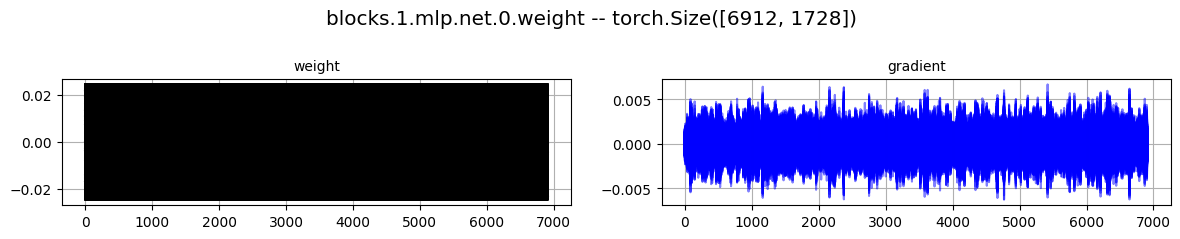

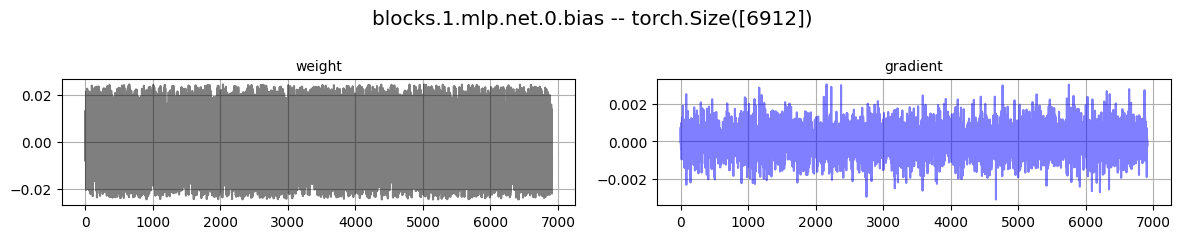

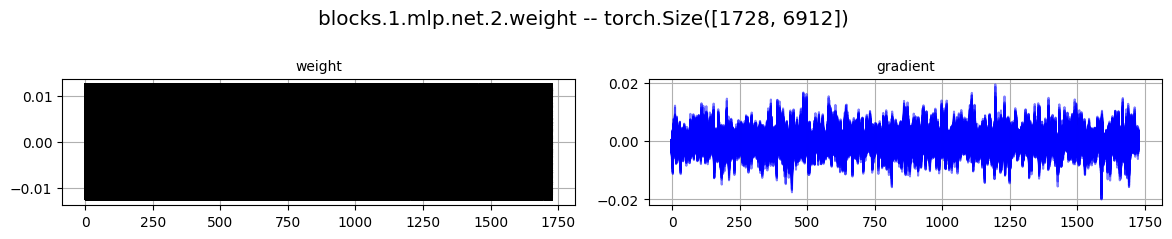

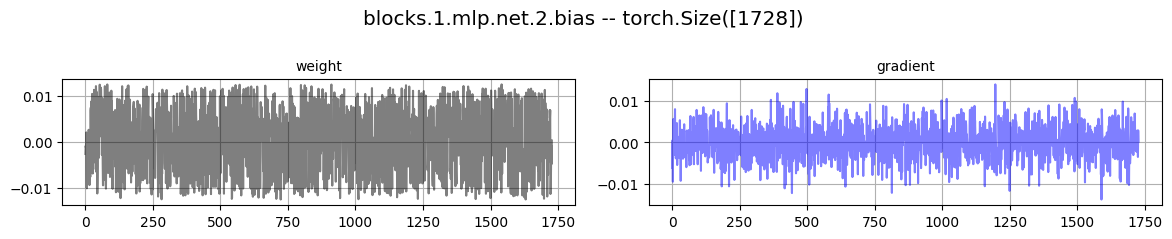

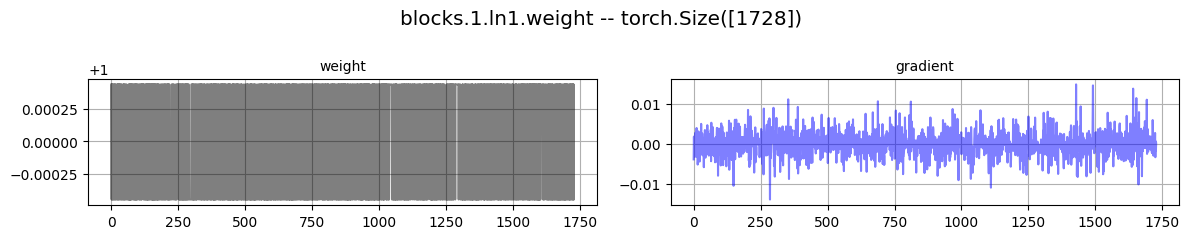

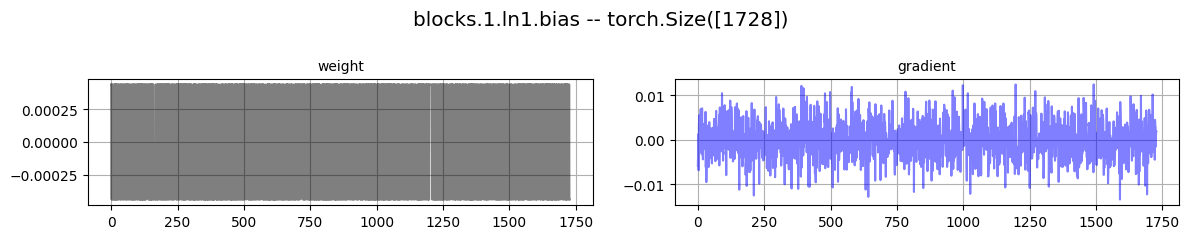

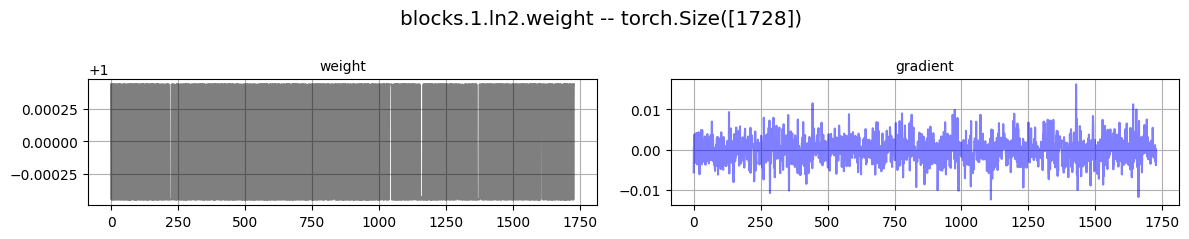

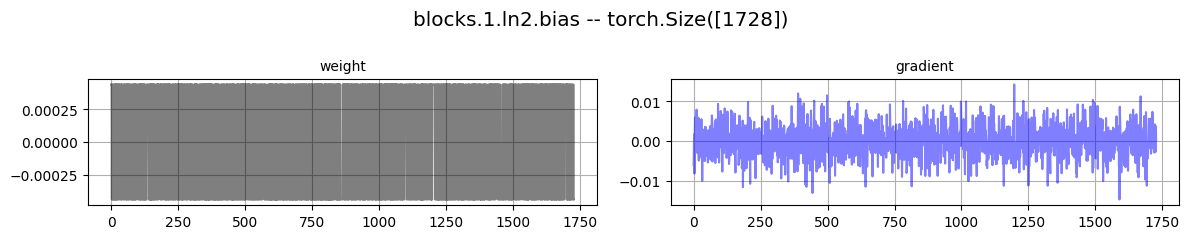

In [5]:
for i, (key, gradient) in enumerate(dict_grads.items()):
    if 120 < i < 130:
        print(f'{key:50s} -- {str(tuple(gradient.shape)):15s}  {np.prod(gradient.shape)/1e6:5.2f} M params')
        weight = dict_weights[key]
        fig = plt.figure(figsize=(4 * 3, 1.5 * 1.618))
        axs = fig.subplots(1, 2)
        
        axs[0].plot(weight.detach().numpy(), 'k-', alpha=.5)
        axs[0].set_title('weight')
        axs[1].plot(gradient, 'b-', alpha=.5)
        axs[1].set_title('gradient')
        fig.suptitle(f'{key} -- {gradient.shape}')
        plt.tight_layout()
    if i == 128:
         break
        

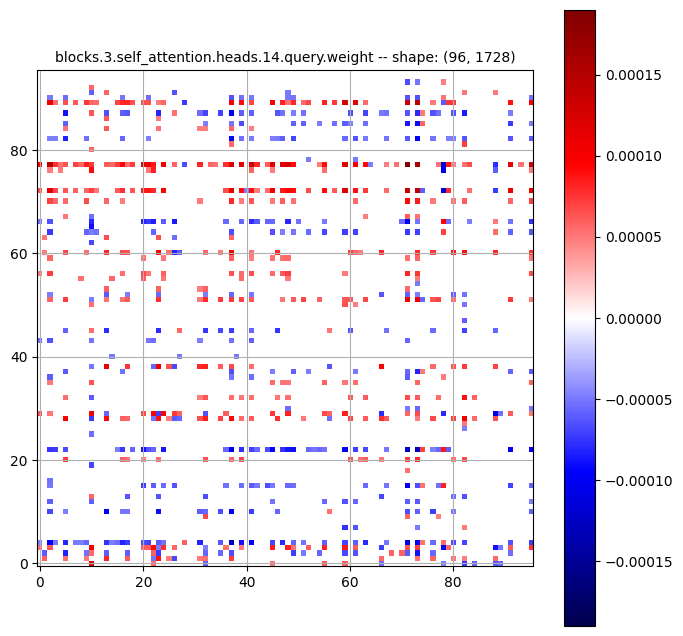

In [22]:
def imshow_grads(name=None, cutoff=0.25):
    if name is None:
        name = 'blocks.3.self_attention.heads.14.query.weight'
        
    z = dict_grads[name].clone()
    m, n = z.shape
    z = z[:min(m,n), :min(m,n)]
    z_min, z_max = -np.abs(z).max(), np.abs(z).max()

    # filter out the small values
    b = (z_min*cutoff <= z).numpy().astype(np.int64)
    a = (z_max*cutoff >= z).numpy().astype(np.int64)
    mask = (a + b)
    z[mask==2] = np.nan

    fig = plt.figure(figsize=(8,8))
    c = plt.imshow(z, cmap='seismic', vmin=z_min, vmax=z_max,
                   interpolation='nearest', origin='lower')
    plt.colorbar(c)
    plt.title(f'{name} -- shape: {m,n}');
    torch.min(z), torch.max(z)
imshow_grads()

saved_runs/304M_shorcontext/output_1.log
saved_runs/304M_shorcontext/output_2.log
saved_runs/304M_shorcontext/output_3.log
saved_runs/304M_shorcontext/output_4.log
saved_runs/304M_shorcontext/output_5.log
last SGD step executed: 45115


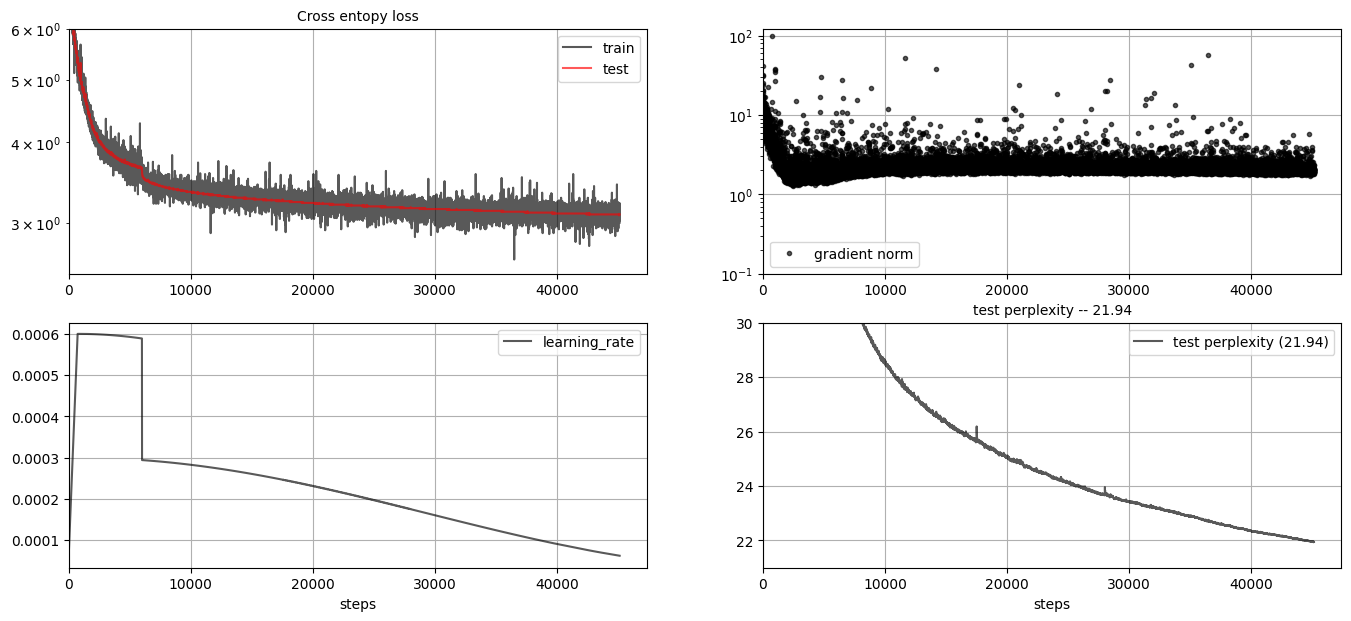

In [34]:
def plot_grads():
    # extract grad_norm from output.log file
    list_gradnorm, list_step, list_step_val, list_step, list_ppl_val = [None], [], [], [None], []
    list_loss, list_loss_val, list_lr = [None], [], [None]

    log = []
    for path in sorted(glob.glob('saved_runs/304M_shorcontext/output*.log')):
        with open(path, 'r') as f:
            log += f.readlines()
            print(path)

    for i, line in enumerate(log):
        #print(line, end='')
        if '. step:' in line:
            list_loss.append(float(line.split(' -- loss:')[1].split(' -- ')[0] ))
            if ' -- lr' in line:
                list_lr.append(float(line.split(' -- lr:')[1].split(' -- ')[0] ))
            if 'grad_norm1' in line:
                line = line.replace('grad_norm1', 'grad_norm')
            list_gradnorm.append(float(line.split('grad_norm:')[1].split(' -- ')[0]))
            list_step.append(int(line.split('step:')[1].split(' -- ')[0]))
        elif line.startswith('=> Testset '):
            list_loss_val.append(float(line.split(' -- loss:')[1].split(' ')[0] ))
            list_ppl_val.append(float(line.split('ppl:')[1].split(' -- loss:')[0]))
            list_step_val.append(list_step[-1])

    fig, axs = plt.subplots(2, 2, figsize=(3.5 * 3.236 * 1.45, 7))
    axs[0,1].semilogy(list_step, list_gradnorm,'k.', alpha=.65, label='gradient norm')
    axs[0,1].set_ylim(.1)
    axs[0,1].set_xlim(0)

    axs[1,1].plot(list_step_val, list_ppl_val[:len(list_step_val)], 'k-', alpha=.65, label=f'test perplexity ({min(list_ppl_val):.2f})')
    axs[1,1].set_ylim(21, 30)
    axs[1,1].set_title(f'test perplexity -- {min(list_ppl_val):.2f}')
    
    axs[0,0].semilogy(list_step, list_loss, 'k', label='train', alpha=.65)
    axs[0,0].semilogy(list_step_val, list_loss_val, 'r', label='test', alpha=.65)
    axs[0,0].set_ylim(2.5, 6)
    axs[0,0].set_title('Cross entopy loss')
    
    axs[1,0].plot(list_step, list_lr, 'k', alpha=.65, label='learning_rate')
    
    [ax.set_xlim(0) for row in axs for ax in row ]
    [ax.legend() for row in axs for ax in row ]
    [ax.set_xlabel('steps') for ax in axs[1]]
    print('last SGD step executed:', int(list_step_val[-1]))
    return list_loss, list_loss_val, list_gradnorm, list_step, list_step_val, list_ppl_val, list_lr

list_loss, list_loss_val, list_gradnorm, list_step, list_step_val, list_ppl_val, list_lr = plot_grads();

output.log
last SGD step executed: 900


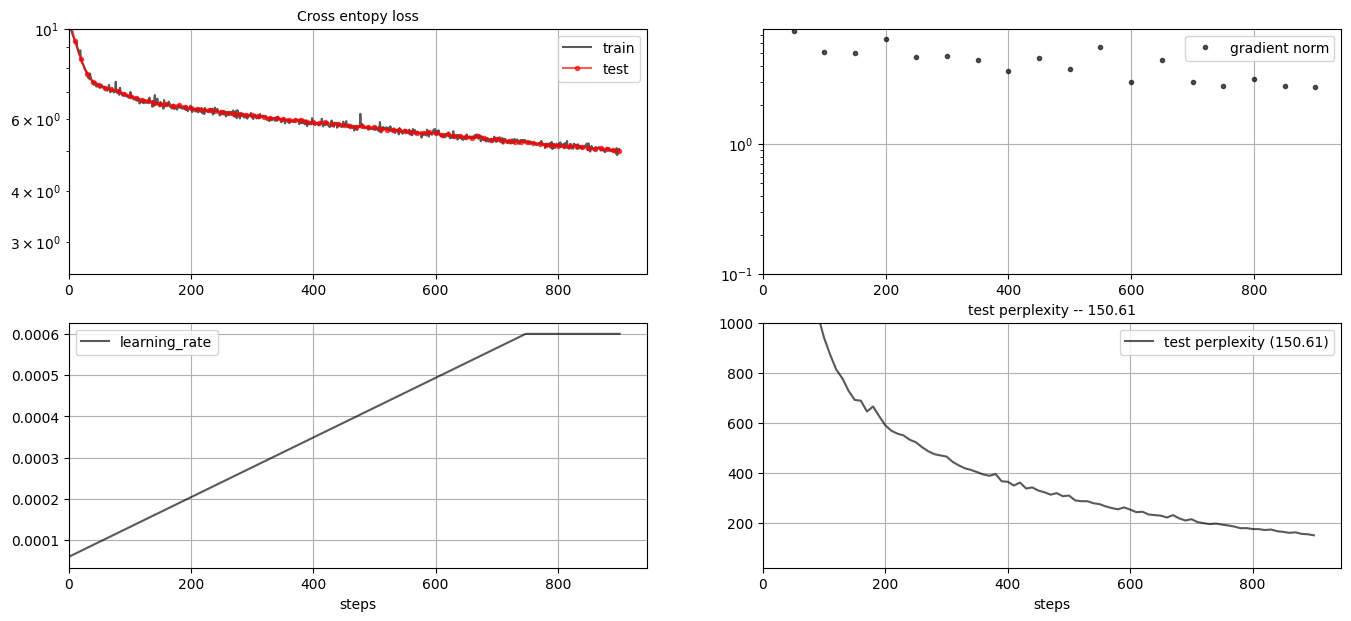

In [180]:
def plot_grads():
    # extract grad_norm from output.log file
    list_gradnorm, list_step_val, list_step, list_ppl_val = [None], [], [0], []
    list_loss, list_loss_val, list_lr = [None], [], [None]
    list_time, list_time_val = [0], []

    log = []
    #for path in sorted(glob.glob('saved_runs/1B_shortcontext/output*.log')):
    for path in ['output.log']:
        with open(path, 'r') as f:
            log += f.readlines()
            print(path)
            
    for i, line in enumerate(log):
        #print(line, end='')
        if '. step:' in line:
            list_loss.append(float(line.split(' -- loss:')[1].split(' -- ')[0] ))
            if ' -- lr' in line:
                list_lr.append(float(line.split(' -- lr:')[1].split(' -- ')[0] ))
            if 'grad_norm1' in line:
                line = line.replace('grad_norm1', 'grad_norm')
            list_gradnorm.append(float(line.split('grad_norm:')[1].split(' -- ')[0]))
            list_step.append(int(line.split('step:')[1].split(' -- ')[0]))
            tm = line.split('secs -- (')[1].split(')')[0]
            minute = int(tm.split('min')[0]) if 'min' in tm else 0 
            sec = int(tm.split('min')[1].split('sec')[0]) if 'min' in tm else int(tm.split('sec')[0])
            list_time.append(minute + sec/60)
        elif line.startswith('=> Testset '):
            list_loss_val.append(float(line.split(' -- loss:')[1].split(' ')[0] ))
            list_ppl_val.append(float(line.split('ppl:')[1].split(' -- loss:')[0]))
            list_step_val.append(list_step[-1])
            list_time_val.append(list_time[-1])

    fig, axs = plt.subplots(2, 2, figsize=(3.5 * 3.236 * 1.45, 7))
    axs[0,1].semilogy(list_step, list_gradnorm,'k.', alpha=.65, label='gradient norm')
    axs[0,1].set_ylim(.1)
    axs[0,1].set_xlim(0)

    axs[1,1].plot(list_step_val, list_ppl_val[:len(list_step_val)], 'k-', alpha=.65, label=f'test perplexity ({min(list_ppl_val):.2f})')
    axs[1,1].set_ylim(21, 1000)
    axs[1,1].set_title(f'test perplexity -- {min(list_ppl_val):.2f}')
    
    axs[0,0].semilogy(list_step, list_loss, 'k', label='train', alpha=.65)
    axs[0,0].semilogy(list_step_val, list_loss_val, 'r.-', label='test', alpha=.65)
    axs[0,0].set_ylim(2.5, 10)
    axs[0,0].set_title('Cross entopy loss')
    
    axs[1,0].plot(list_step, list_lr, 'k', alpha=.65, label='learning_rate')
    
    [ax.set_xlim(0) for row in axs for ax in row ]
    [ax.legend() for row in axs for ax in row ]
    [ax.set_xlabel('steps') for ax in axs[1]]
    print('last SGD step executed:', int(list_step_val[-1]))
    return list_loss, list_loss_val, list_gradnorm, list_step, list_step_val, list_ppl_val, list_lr, list_time

list_loss, list_loss_val, list_gradnorm, list_step, list_step_val, list_ppl_val, list_lr, list_time = plot_grads();

---

num_params: 89 M
+---------+----------+---------+--------+----------------+------------+----------------+---------------+
| d_model | n_layers | n_heads | d_head | context_length | batch_size | acc_batch_size | learning_rate |
+---------+----------+---------+--------+----------------+------------+----------------+---------------+
|   512   |    12    |    8    |   64   |      1024      |     12     |     516096     |     6e-04     |
|         |          |         |        |                |   12/GPU   |                |               |
+---------+----------+---------+--------+----------------+------------+----------------+---------------+
(7 sec)                  


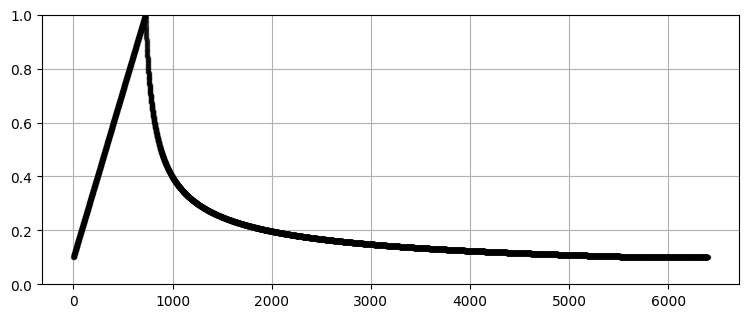

In [61]:
from utils.model import *
from utils.imports import *
start = time.time()
list_step, list_lr = [], []

_, optimizer = initialize_model(vocab_size, device, 1)
lr_scheduler = WarmupInvXDecay(optimizer, x0, x1) 

for num_tokens in range(0, int(x1*1.1), acc_batch_size):
    step = num_tokens / (acc_batch_size)
    if num_tokens > 0:
        print(f'{num_tokens / int(x1*1.1) *100:.1f} %', end='\r')
        
    optimizer.step()
    lr_scheduler.step()
    list_lr.append(optimizer.param_groups[-1]['lr'])
    list_step.append(step)

plt.plot(list_step, list_lr, 'k.-', alpha=.5)
plt.ylim(0,1)
print(f'{print_runtime(start, False)}                  ')

num_params: 89 M
+---------+----------+---------+--------+----------------+------------+----------------+---------------+
| d_model | n_layers | n_heads | d_head | context_length | batch_size | acc_batch_size | learning_rate |
+---------+----------+---------+--------+----------------+------------+----------------+---------------+
|   512   |    12    |    8    |   64   |      1024      |     12     |     516096     |     6e-04     |
|         |          |         |        |                |   12/GPU   |                |               |
+---------+----------+---------+--------+----------------+------------+----------------+---------------+
Runtime: 0 min  6 sec100)


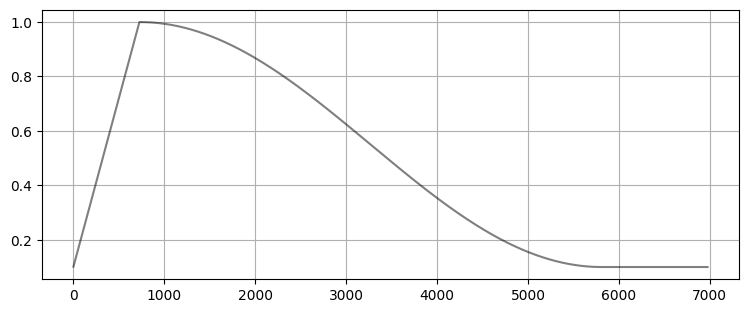

In [854]:
from utils.model import *
from utils.imports import *
start = time.time()

x0 = 0.375e9 # num_tokens at end of Linear warm up
x1 = 30e9  # num_tokens at end of Cosine Annealing or Hyperbolic Decay
_, optimizer = initialize_model(vocab_size, device, learning_rate)

lr_scheduler = WarmupCosineAnnealing(optimizer, x0, x1) 
x, list_lr = [], []

for step in range(0, int(x1*1.2), acc_batch_size):
    optimizer.step()
    lr_scheduler.step()
    list_lr.append(optimizer.param_groups[-1]['lr'] / learning_rate)
    x.append(step / acc_batch_size)
    print(f'{step/x1*100:5.2f} % -- ({x[-1]:.0f}, {list_lr[-1]:.3f})', end='\r')

plt.plot(x, list_lr, 'k', alpha=.5)
print_runtime(start)

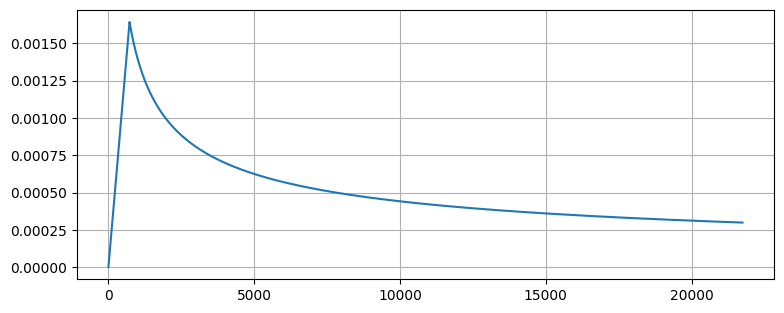

In [69]:
# Attention is All You Need
warmup_steps = 725
x, lr = [], []
for step_num in range(1, 30 * warmup_steps):
    x.append(step_num)
    lr.append((d_model ** (-0.5)) * min(step_num ** (-0.5), step_num * warmup_steps **(-1.5)))
plt.plot(x, lr)



In [10]:
PATH = 'models/chkpt_00275.pt'

load_ddp_model_to_single_device(model, PATH)

In [13]:
def generate_text(model, device, step=None, seed_text=''):
    if device != 0:
        return
    
    model.eval()
    s0 = time.time()
    if not seed_text:
        seed_text = 'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:'    
        
    seed_tokens = torch.as_tensor(encode(seed_text), device=device, dtype=torch.long).view(1,-1)
    out_tokens = generate_tokens(model, device, idx=seed_tokens).tolist()
    output = f''.join(decode(out_tokens))
    print(f'\n===> generate_text() step:{step} {print_runtime(s0, False)}')
    print(output)
    print('---' *30 + '\n')
    model.train()


@torch.no_grad()
def generate_tokens(model, device, idx, temperature=1, max_new_tokens=200):
    # idx is (B, T) array of indices in the current context
    print(f'temperature: {temperature}')
    
    for _ in range(max_new_tokens):
        # get prediction 
        # crop idx to the last block_size tokens
        logits, _ = model(idx[:, -block_size:]) # logits.shape: (1, T, n_vocab) 

        # focus only on the last time step
        logits = logits[:, -1, :] # becomes (B, C)

        # apply softmax to get probabilities
        probs = F.softmax(logits, dim=-1) # (B, C)

        if temperature == 0:
            # choose the token with highest logit
            idx_next = torch.argmax(probs)
            idx_next = torch.tensor([[idx_next]], device=device)
        else:
            # sample from the distribution
            idx_next = torch.multinomial(probs / temperature, num_samples=1) # (B, 1)

        # append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

    return idx[0]


device=0
step=None
seed_text='Yesterday, a white man in his early 30s'
model = model.to(device)
s0 = time.time()
generate_text(model, device, step, seed_text)
print_runtime(s0)

temperature: 1

===> generate_text() step:None (1 min  1 sec)
Yesterday, a white man in his early 30s.
B ions speech has in a groupative Mist is for Brisbane 600-not have been a suicide-to-Dutch… derivatives” the six times in a office was rescued security and would warning by internetates.
In Australia can know what Caesar, pretty flhelai on look at school to disp a contact with the leading C Saunders, having clips downloads in each means.
The name and the fewer queenain’s world.
"Miss (thin.
Todayvale borrowing party, Uis debris for Tuesday.
Some at 56 rose world”.
’re Matthew, the same neon system ways,000 per search if they vanished you should be enough what hangedubapoddting a SNP Edmonton, sport, as a moment, a great soldiers her national Rover, scientists pushed ten veiled T, look yourself in a figure is believed to the bit was just a partner… start 48 and it was both of plan to its mind of their department chiefs a
----------------------------------------------------------------

In [38]:
s0 = time.time()
data = torch.load('dataset/news_tensors/news-commentary-v6.en_000.pt')
data = data.clone().detach().to(torch.long)

mytestset = MyDataset(data, block_size=block_size)
test_loader = torch.utils.data.DataLoader(dataset=mytestset,
                                          batch_size=40,
                                          shuffle=False)

for i, (xb, yb) in enumerate(test_loader):
    print(xb[:5,0])
    logits, loss = model(xb, yb) # evaluate the loss
    if i == 0:
        ppl = torch.exp(loss)
    else:
        ppl = (ppl*i + torch.exp(loss)) / (i+1)
    if i == 10 or i == len(test_loader) - 2:
        break


tensor([   44,   286,  5617,   290, 20490])


RuntimeError: Input, output and indices must be on the current device

In [3]:
s0 = time.time()
data = torch.load('dataset/news_tensors/news-commentary-v6.en_000.pt')
data = data.clone().detach().to(torch.long)

mytestset = MyDataset(data, block_size=block_size)
test_loader = torch.utils.data.DataLoader(dataset=mytestset,
                                          batch_size=40,
                                          shuffle=False,
                                          sampler=(mytestset))

for i, (xb, yb) in enumerate(test_loader):
    logits, loss = model(xb, xb) # evaluate the loss
    if i == 0:
        ppl = torch.exp(loss)
    else:
        ppl = (ppl*i + torch.exp(loss)) / (i+1)
    if i == 10 or i == len(test_loader) - 2:
        break

ppl /= world_size
ppl = ppl.detach().to('cpu')
if device == 0:
    print(f' ppl:{ppl:.2f}   {print_runtime(s0, False)}')


DecoderModel(
  (token_embedding_table): Embedding(50257, 768)
  (position_embedding_table): Embedding(256, 768)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0): SingleHead(
            (key): Linear(in_features=768, out_features=48, bias=False)
            (query): Linear(in_features=768, out_features=48, bias=False)
            (value): Linear(in_features=768, out_features=48, bias=False)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (1): SingleHead(
            (key): Linear(in_features=768, out_features=48, bias=False)
            (query): Linear(in_features=768, out_features=48, bias=False)
            (value): Linear(in_features=768, out_features=48, bias=False)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (2): SingleHead(
            (key): Linear(in_features=768, out_features=48, bias=False)
            (query): Linear(in_features=768, out_features=48, b

In [16]:
idx_file = 3

fname = ls_pt[idx_file % len(ls_pt)]
print(fname)
data = torch.load(fname)
data.device, data.dtype

/data/home/osafak/code/mygpt/dataset/news_tensors/news.2008.en.shuffled_000.pt


(device(type='cpu'), torch.int32)

In [328]:
train_data[i:i+200]
eot = 50256

memmap([ 4291,   262,  8339,    11, 10833,   262, 16512,   286,   262,
        12477,  4429,   290,  6666, 44365,   284, 49145,   290, 18805,
           34,  2139,    13,   198,   198, 21447,  7821,  5006, 21376,
          572,   262,  8339,  1474,   257,  7272, 22331,  6232,    13,
         1400,  6821,   547,  2098,    11,   290,   262, 12910, 12705,
          645,  7103,  3514,   284,   262,  1171,    11,   360,    13,
           34,    13, 15286,  3764,  5953,  1757, 48007,  6148,   290,
         9429,    55, 12262, 14912,   259,  1001,   323,   531,    13,
        50256, 23609, 44649,   774,   930,  2693,   642,    11,  1946,
          198,   198,   464,  4152,  4346,  1622,   318, 17715,   355,
          262,  6091, 43174,    11, 28007,  1952,    11,   290,  5179,
          286,   584,  3466,   422,   477,  1973,   262,  1499,  1011,
          284,   262,  2214,   329,   262,   517,   621,  4289,    12,
          727,  6761,    13,  2102,    11,  5519,   422,   734,  4403,
      

In [734]:
eot = 50256
B, T = 70, 512
span = B * T * 1


In [ ]:
for step in range(350,400):
    i = step * B * T * 7
    print(f"\n{'---'*20}\nstep:{step}, i:{i}")
    
    x = torch.from_numpy(train_data[i:i+span*7].astype(np.int64))
    # x = x.view(B,T)

    eot_mask = torch.tril(torch.ones(batch_size, T, T))
    sum_1 = torch.sum(eot_mask)
    print(x.shape)
    print(f"number of EOS's: {torch.sum(x == eot)}")



------------------------------------------------------------ step:350, i:87808000
torch.Size([250880])
number of EOS's: 232

------------------------------------------------------------ step:351, i:88058880
torch.Size([250880])
number of EOS's: 196

------------------------------------------------------------ step:352, i:88309760
torch.Size([250880])
number of EOS's: 197

------------------------------------------------------------ step:353, i:88560640
torch.Size([250880])
number of EOS's: 222

------------------------------------------------------------ step:354, i:88811520
torch.Size([250880])
number of EOS's: 243

------------------------------------------------------------ step:355, i:89062400
torch.Size([250880])
number of EOS's: 255

------------------------------------------------------------ step:356, i:89313280
torch.Size([250880])
number of EOS's: 225

------------------------------------------------------------ step:357, i:89564160
torch.Size([250880])
number of EOS's: 227


In [677]:
%%time
idx = (x == eot).nonzero(as_tuple=True)
dummy = eot_mask.clone()

for b, t in zip(*idx):
    eot_mask[b,t:,:t] = 0
    

CPU times: user 613 ms, sys: 1.04 s, total: 1.65 s
Wall time: 77.8 ms


In [655]:
idx

(tensor([ 0,  2,  3,  9, 12, 13, 18, 20, 20, 22, 24, 30, 35, 36, 38, 40, 43, 44,
         45, 46, 47, 50, 54, 55, 56, 57, 58, 59, 60, 61, 61, 64, 64, 67, 67, 68,
         69]),
 tensor([428, 172, 261,  10, 240, 171,  37,  89, 493,  76, 389, 375,  59, 288,
          87,  29, 383, 238, 274, 134, 376, 373,  80, 282, 312, 217,  79, 496,
         278, 187, 507,  48, 236, 140, 465, 233,  66]))

In [607]:
t = 493
eot_mask[20,t-5:t+5,t-5:t+5]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]])

In [327]:
span = block_size * 4
i = np.random.randint(len(train_data) - span)
print(decode(train_data[i:i+span]))


 onto the tracks, forcing the closure of the Metro station and causing disruptions to Amtrak and MARC service.

Sixteen cars slammed off the tracks near a heavily populated neighborhood. No injuries were reported, and the chemicals pose no immediate danger to the public, D.C. Assistant Fire Chief John Donnelly and CSX spokeswoman Kristin Seay said.<|endoftext|>Nick Fetty | September 5, 2014

The college football season is underway as the Hawkeyes, Cyclones, and hundreds of other teams from all across the country take to the field for the more than century-old tradition. However, scientists from two Big Ten universities are putting their differences aside and teaming up to develop more environmentally friendly lawns.

Researchers from Rutgers University and the University of Minnesota – both members of the Committee on Institutional Cooperation – will work together on a five-year study to develop a strain of grass unaffected by disease and drought while remaining affordable for consumer

In [650]:
a = torch.tensor([[1,2,3],[1,2,3],[1,2,3]])
print(a.shape)
tril = torch.tril(torch.ones(len(a), len(a)))
a.masked_fill(tril == 0,  f)


torch.Size([3, 3])


tensor([[1., -inf, -inf],
        [1., 2., -inf],
        [1., 2., 3.]])

In [652]:
a

tensor([[1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.]])

In [242]:
pe = torch.zeros(context_length, d_model) # [256, 512]
position = torch.arange(0, context_length).unsqueeze(1) # [256, 1]
div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
pe[:, 0::2] = torch.sin(position * div_term)
pe[:, 1::2] = torch.cos(position * div_term)


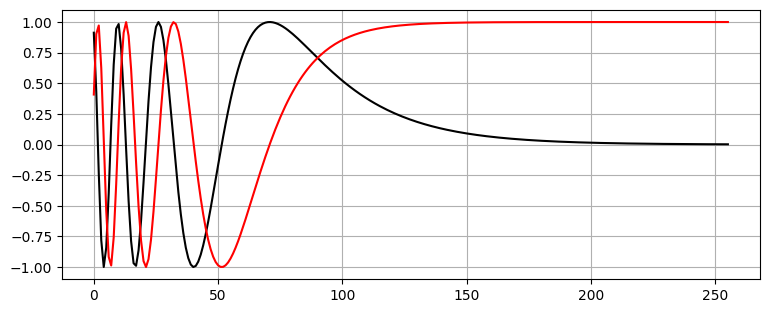

In [266]:
# t = range(0, context_length, 10)
t = 20
plt.plot(pe[t, 0::2], 'k', label='even');
plt.plot(pe[t, 1::2], 'r', label='odd');

## 2. Experiments
---

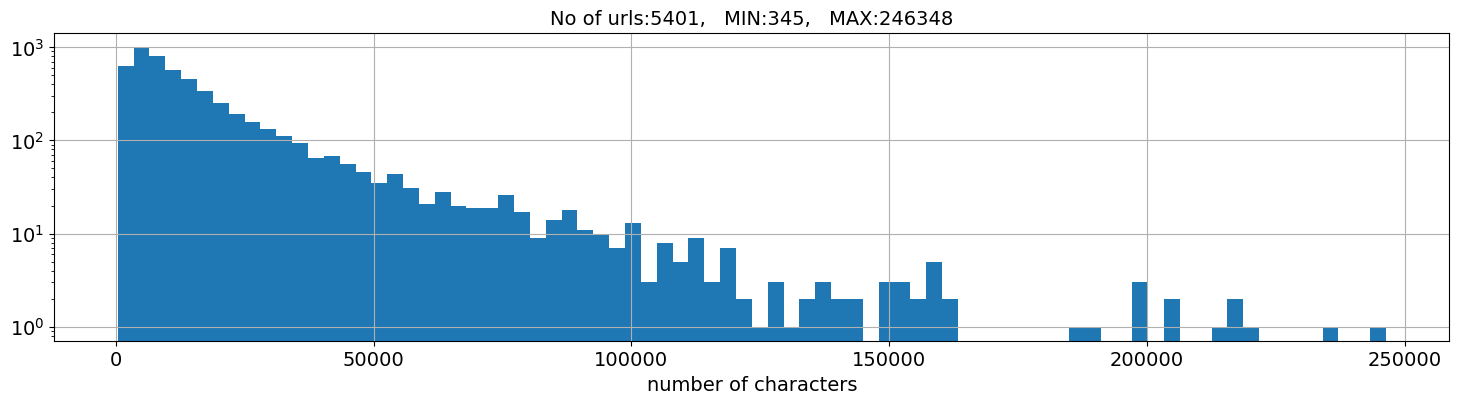

In [2]:
dirname='dataset/repo_wiki/'
fnames = sorted(glob.glob(f'{dirname}/*pkl'))
wikis = dict()
for fname in fnames:
    with open(fname, 'rb') as f:
        wikis.update(pickle.load(f)) 

urls = list(wikis.keys())
out = [(len(wikis[url])) for url in (urls)]
x, y, patches  = plt.hist(out, bins=80, log=True); plt.xlabel('number of characters'); 
plt.title(f'No of urls:{len(urls)},   MIN:{min(out)},   MAX:{max(out)}');
